# Zadanie 4
Wykorzystanie techniki transferu w uczeniu z nadzorem na bazie danych VGGFace:
• Zadanie polega na wykorzystaniu istniejącego modelu głębokiej sieci neuronowej, np.
VGG16, w celu klasyfikacji twarzy na podstawie danych z bazy danych VGGFace.
• Użyj bazy danych VGGFace, która zawiera miliony zdjęć twarzy różnych osób.
• Wczytaj pre-trenowany model z Keras, a następnie dostosuj go do nowego zadania klasyfikacji za pomocą techniki transferu w uczeniu z nadzorem.
Ocenić wydajność modelu na zbiorze testowym oraz zwizualizuj wyniki za pomocą macierzy pomyłek.

In [113]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sea

from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc

In [114]:
# Ładowanie danych które są zdjęciami z UTKFace gdzie labele zawierają w nazwie plików w formie age_gender_race_date.jpg
import os
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array
import pickle

def load_data(data_dir):
    images = []
    labels = []
    
    for file_name in os.listdir(data_dir):
        if file_name.endswith(".jpg"):
            # Parsowanie informacji z nazwy pliku
            parts = file_name.split('_')
            age = int(parts[0])
            gender = int(parts[1])
            race = int(parts[2])
            
            # Ścieżka do pliku
            file_path = os.path.join(data_dir, file_name)
            
            # Wczytanie obrazu
            img = Image.open(file_path)
            img = img.resize((32, 32))  # Zmiana rozmiaru obrazu do 32x32 (mój laptop nie pociągnie większego uczenia)
            img_array = img_to_array(img)  # Konwersja obrazu do tablicy numpy
            
            # Normalizacja obrazu
            img_array = img_array / 255.0
            
            # Dodanie obrazu i etykiet do list
            images.append(img_array)
            labels.append([age, gender, race])
    
    # Konwersja list do tablic numpy
    X = np.array(images)
    Y = np.array(labels)
    
    return X, Y

def save_data_to_pkl(data_dir, X, Y):
    # Zapisywanie numpy array do pliku pickle
    with open(data_dir+"X.pkl", 'wb') as f:
        pickle.dump(X, f)
    with open(data_dir+"Y.pkl", 'wb') as f:
        pickle.dump(Y, f)
    print("Zapisanie do formatu pkl")

def load_data_from_pk(data_dir):
    # Wczytywanie numpy array z pliku pickle
    with open(data_dir+"X.pkl", 'rb') as f:
        X = pickle.load(f)
    with open(data_dir+"Y.pkl", 'rb') as f:
        Y = pickle.load(f)
    return X,Y

# Użycie funkcji wczytującej dane z plików za pierwszym razem ( potem nie warto powtarzać tego)
"""


"""
data_dir = 'Data/UTKFace/'
X, Y = load_data(data_dir)

# z powodu słabego sprzętu ograniczymy się tylko do płci
Y = Y[:, 1]

In [115]:
# funkcje wczytujące z formatu pkl (jeszcze nie działa)
"""
data_dir = 'Data/UTKFacePKL/'
save_data_to_pkl(data_dir, X, Y)
X, Y = load_data(data_dir)

# Przykładowe wyświetlenie kształtów macierzy

X
"""

"\ndata_dir = 'Data/UTKFacePKL/'\nsave_data_to_pkl(data_dir, X, Y)\nX, Y = load_data(data_dir)\n\n# Przykładowe wyświetlenie kształtów macierzy\n\nX\n"

In [147]:
# Podział danych na zbiór treningowy i testowy
print("X shape:", X.shape)
print("Y shape:", Y.shape)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
x_train

X shape: (7669, 32, 32, 3)
Y shape: (7669,)


array([[[[0.99215686, 0.8745098 , 0.30588236],
         [0.9764706 , 0.85882354, 0.27450982],
         [0.8       , 0.70980394, 0.24313726],
         ...,
         [0.2       , 0.15686275, 0.12156863],
         [0.14509805, 0.1254902 , 0.11372549],
         [0.12941177, 0.1254902 , 0.10588235]],

        [[0.9882353 , 0.8745098 , 0.2901961 ],
         [0.9882353 , 0.87058824, 0.27058825],
         [0.8392157 , 0.7490196 , 0.2784314 ],
         ...,
         [0.21960784, 0.16470589, 0.12156863],
         [0.15686275, 0.13333334, 0.10980392],
         [0.13333334, 0.12941177, 0.10196079]],

        [[0.9843137 , 0.8666667 , 0.27058825],
         [0.9882353 , 0.8784314 , 0.27450982],
         [0.85490197, 0.7647059 , 0.28627452],
         ...,
         [0.23921569, 0.18039216, 0.13725491],
         [0.17254902, 0.15294118, 0.11764706],
         [0.14117648, 0.14509805, 0.09803922]],

        ...,

        [[0.94509804, 0.9098039 , 0.8745098 ],
         [0.95686275, 0.88235295, 0.7176471 ]

In [117]:
y_train

array([0, 1, 1, ..., 0, 1, 1])

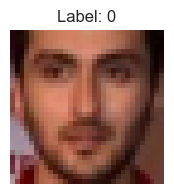

In [134]:
# Wyświetlenie przykładowego zdjęcia
plt.figure(figsize=(2,2))  # Ustawienie rozmiaru figury
plt.imshow(x_train[3], cmap='BuPu')  # Wyświetlenie pierwszego zdjęcia w zbiorze treningowym
plt.title('Label: {}'.format(y_train[3]))  # Tytuł zawierający etykietę zdjęcia
plt.axis('off')  # Wyłączenie osi
plt.show()

In [135]:
# Stworzenie modelu vggface
vggface_model = VGG16(include_top=False, input_shape=(32, 32, 3))

In [186]:
# Zdefiniowanie modelu
model = Sequential()
model.add(vggface_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))  
model.add(Dense(32, activation='relu'))  
model.add(Dense(2, activation='softmax'))  

In [187]:
# Kompilowanie modelu
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [188]:
# Trenowanie modelu mała liczba epok spowodowana słabym sprzętem
history = model.fit(x_train, y_train, epochs=2, validation_data=(x_test, y_test))

Epoch 1/2
192/192 [==============================] - 296s 2s/step - loss: 0.6615 - accuracy: 0.6033 - val_loss: 0.6209 - val_accuracy: 0.6584
Epoch 2/2
192/192 [==============================] - 341s 2s/step - loss: 0.5944 - accuracy: 0.6750 - val_loss: 0.5576 - val_accuracy: 0.7347


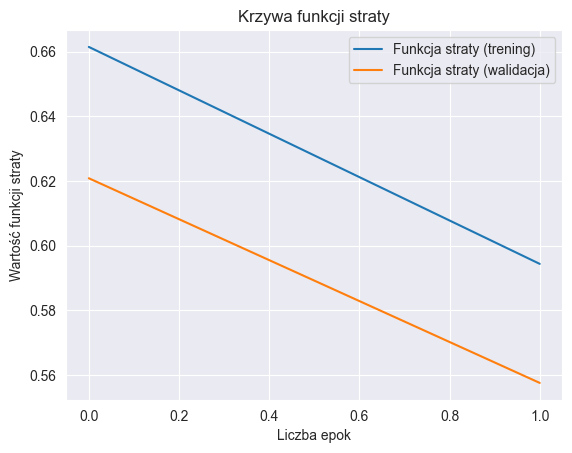

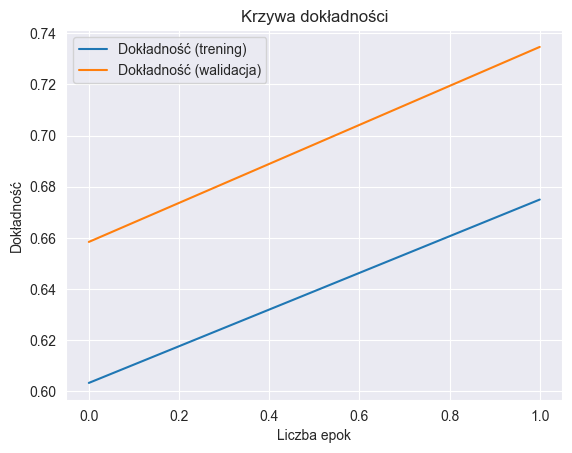

In [197]:
# Wizualizacja krzywych uczenia
plt.plot(history.history['loss'], label='Funkcja straty (trening)')
plt.plot(history.history['val_loss'], label='Funkcja straty (walidacja)')
plt.xlabel('Liczba epok')
plt.ylabel('Wartość funkcji straty')
plt.legend()
plt.title('Krzywa funkcji straty')
plt.show()
plt.plot(history.history['accuracy'], label='Dokładność (trening)')
plt.plot(history.history['val_accuracy'], label='Dokładność (walidacja)')
plt.xlabel('Liczba epok')
plt.ylabel('Dokładność')
plt.legend()
plt.title('Krzywa dokładności')
plt.show()

In [190]:
# Ocena modelu
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Dokładność klasyfikacji:', test_acc)

48/48 [==============================] - 12s 254ms/step - loss: 0.5576 - accuracy: 0.7347
Dokładność klasyfikacji: 0.7346805930137634


In [191]:
# Tworzenie Predykcji
y_pred = model.predict(x_test)

48/48 [==============================] - 11s 216ms/step


In [192]:
# Wartości predykcji przed zmianą na binarne
y_pred

array([[0.0525989 , 0.94740117],
       [0.03790686, 0.9620931 ],
       [0.12708148, 0.8729185 ],
       ...,
       [0.07966073, 0.9203393 ],
       [0.02706931, 0.97293067],
       [0.4152378 , 0.5847621 ]], dtype=float32)

In [193]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

[455 672]


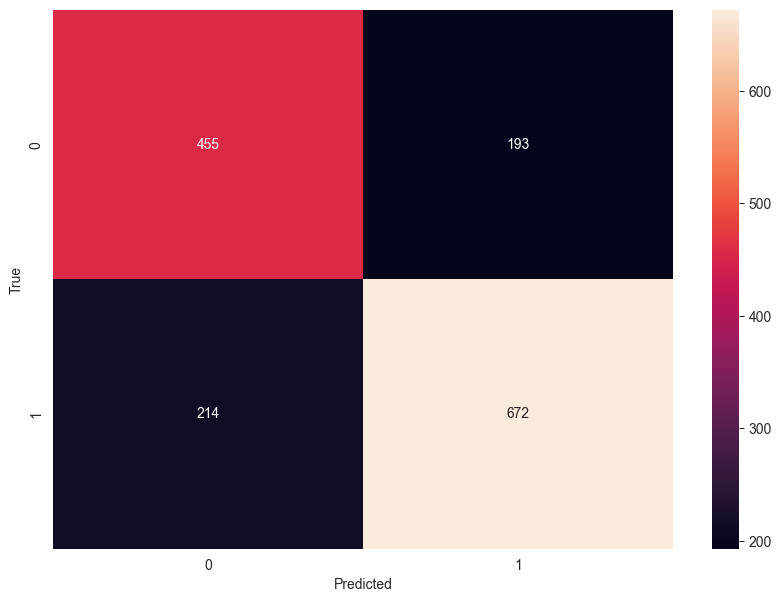

In [194]:
# Obliczenie confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm.diagonal())

# Tworzenie DataFrame z confusion matrix
df_cm = pd.DataFrame(cm, index = [i for i in range(2)], columns = [i for i in range(2)])

# Tworzenie heatmapy confusion matrix
plt.figure(figsize = (10,7))
sea.heatmap(df_cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [195]:
# Czułość modelu:
recall = recall_score(y_test, y_pred, average='micro')
print("Czułość modelu: {:.2f}%".format(recall * 100))

# Obliczenie precyzji
precision = precision_score(y_test, y_pred, average='micro')
print("Precyzja modelu: {:.2f}%".format(precision * 100))

# Obliczenie dokładności modelu
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność modelu:", accuracy)

Czułość modelu: 73.47%
Precyzja modelu: 73.47%
Dokładność modelu: 0.7346805736636245


In [207]:
# Wczytanie własnej twarzy do testu
x_m, y_m = load_data("data/my_face")

In [209]:
y_m = model.predict(x_m)
y_m

1/1 [==============================] - 0s 103ms/step


array([[0.474455, 0.525545]], dtype=float32)

In [210]:
y_pred = np.argmax(y_pred)
y_pred

0

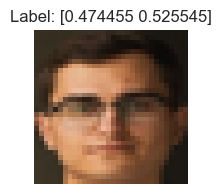

In [211]:
# Wyświetlenie przykładowego zdjęcia
plt.figure(figsize=(2,2))  # Ustawienie rozmiaru figury
plt.imshow(x_m[0], cmap='BuPu')  # Wyświetlenie pierwszego zdjęcia w zbiorze treningowym
plt.title('Label: {}'.format(y_m[0]))  # Tytuł zawierający etykietę zdjęcia
plt.axis('off')  # Wyłączenie osi
plt.show()

# Wnioski
Model w formie prymitywnej względem początkowych zamiarów ( na starcie miałem przewidywać wiek,płeć, oraz rasę) poprawnie wykrył moją płeć co można uznać za minimalny efekt.